# 0.0. IMPORTS

In [1]:
import datetime
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as ss
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from kaggle.api.kaggle_api_extended import KaggleApi
from os import remove
from zipfile import ZipFile

## 0.1. Helper Functions

In [2]:
def cramer_v(df1, df2):
    """ calculate Cramers V statistic for categorial-categorial association.
    """
    
    confusion_matrix = pd.crosstab(df1, df2).as_matrix()
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

## 0.2. Basic Settings

In [3]:
warnings.filterwarnings('ignore')
seed = 0


## 0.3. Loading Data

In [4]:
kaggle = KaggleApi()
kaggle.authenticate()
kaggle.dataset_download_file('hariharanpavan/bank-marketing-dataset-analysis-classification', 'bank-full.csv')

with ZipFile('bank-full.csv.zip', 'r') as Zip:
    Zip.extractall()
    
df_raw = pd.read_csv('bank-full.csv')

remove('bank-full.csv')
remove('bank-full.csv.zip')

# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns = ['age', 'job', 'marital_status', 'education_level', 'default', 'balance', 'housing_loan',
               'loan', 'contact_way', 'day_of_month_lc', 'month_lc', 'duration_lc', 'contact_count', 'days_p',
               'contact_count_p', 'y_p', 'y']

## 1.2. Data Dimensions

In [7]:
print("Number of Rows: {}".format(df1.shape[0]))
print("Number of Columns: {}".format(df1.shape[1]))

Number of Rows: 45211
Number of Columns: 17


## 1.3. Data Types

In [8]:
# Rectifying Booleans
df1 = df1.applymap(lambda x: True if x == 'yes' else x)
df1 = df1.applymap(lambda x: False if x == 'no' else x)

df1.dtypes

age                 int64
job                object
marital_status     object
education_level    object
default              bool
balance             int64
housing_loan         bool
loan                 bool
contact_way        object
day_of_month_lc     int64
month_lc           object
duration_lc         int64
contact_count       int64
days_p              int64
contact_count_p     int64
y_p                object
y                    bool
dtype: object

## 1.4. Check NA

In [9]:
df1 = df1.applymap(lambda x: np.nan if x == 'unknown' else x)
df1.isna().sum()

age                    0
job                  288
marital_status         0
education_level     1857
default                0
balance                0
housing_loan           0
loan                   0
contact_way        13020
day_of_month_lc        0
month_lc               0
duration_lc            0
contact_count          0
days_p                 0
contact_count_p        0
y_p                36959
y                      0
dtype: int64

## 1.5. Fillout NA

In [10]:
#job                  
df1['job'] = df1['job'].fillna('unemployed')

# education_level 
df1['education_level'] = df1['education_level'].fillna("secondary")

#contact_way        
df1['contact_way'] = df1['contact_way'].fillna("cellular")

#y_p                
df1['y_p'] = df1['y_p'].fillna("failure")

## 1.6. Change Data Types

## 1.7. Descriptive Statistics

In [11]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'bool'])
bool_attributes = df1.select_dtypes(include = ['bool'])

### 1.7.1 Numerical Attributes

In [12]:
# Central Tendency
means = pd.DataFrame(num_attributes.apply(np.mean)).T
medians = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
stds = pd.DataFrame(num_attributes.apply(np.std)).T
skews = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtoses = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
maxima = pd.DataFrame(num_attributes.apply(max)).T
minima = pd.DataFrame(num_attributes.apply(min)).T
value_range = pd.DataFrame(num_attributes.apply(lambda x: max(x) - min(x))).T

In [13]:
stats = pd.concat([minima, maxima, value_range, means, medians, stds, skews, kurtoses]).T
stats.columns = ["Min", "Max", "Range", "Mean", "Median", "Std", "Skew", "Kurtosis"]
stats

,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
age,18.0,95.0,77.0,40.936210,39.0,10.618645,0.684818,0.319570
balance,-8019.0,102127.0,110146.0,1362.272058,448.0,3044.732156,8.360308,140.751547
day_of_month_lc,1.0,31.0,30.0,15.806419,16.0,8.322384,0.093079,-1.059897
duration_lc,0.0,4918.0,4918.0,258.163080,180.0,257.524964,3.144318,18.153915
contact_count,1.0,63.0,62.0,2.763841,2.0,3.097987,4.898650,39.249651
days_p,-1.0,871.0,872.0,40.197828,-1.0,100.127639,2.615715,6.935195
contact_count_p,0.0,275.0,275.0,0.580323,0.0,2.303416,41.846454,4506.860660


### 1.7.2. Categorical Attributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

job                11
marital_status      3
education_level     3
contact_way         2
month_lc           12
y_p                 3
dtype: int64

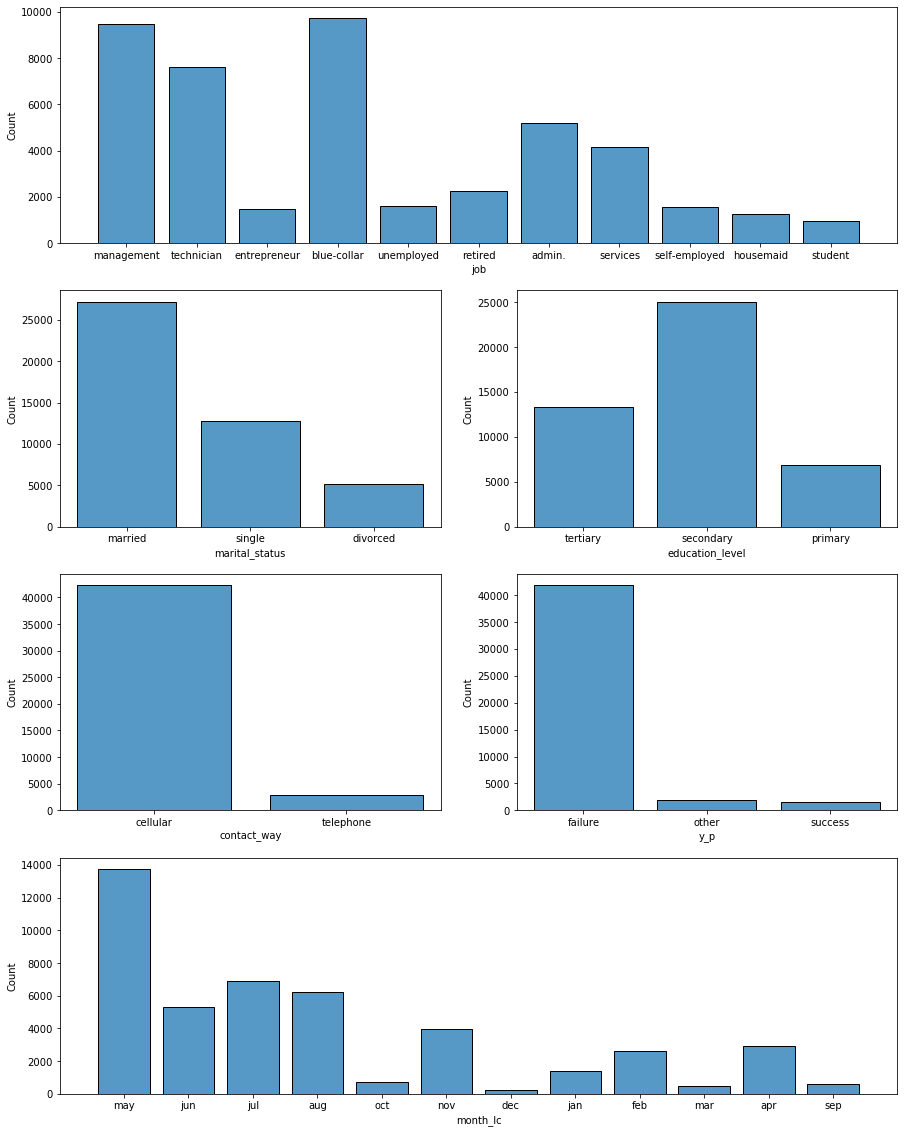

In [15]:
# CONSERTAR ORDEM DO ULTIMO GRAFICO

plt.figure(figsize = [15, 20])

plt.subplot(4, 1, 1)
sns.histplot(x = 'job', data = cat_attributes, shrink=.8)

plt.subplot(4, 2, 3)
sns.histplot(x = 'marital_status', data = cat_attributes, shrink=.8)

plt.subplot(4, 2, 4)
sns.histplot(x = 'education_level', data = cat_attributes, shrink=.8)

plt.subplot(4, 2, 5)
sns.histplot(x = 'contact_way', data = cat_attributes, shrink=.8)

plt.subplot(4, 2, 6)
sns.histplot(x = 'y_p', data = cat_attributes, shrink=.8)

plt.subplot(4, 1, 4)
sns.histplot(x = 'month_lc', data = cat_attributes, shrink=.8, hue_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'out', 'nov', 'dec']);

### 1.7.3. Booleans Attributes

In [16]:
bool_attributes.sample()

,default,housing_loan,loan,y
31956,False,True,False,False


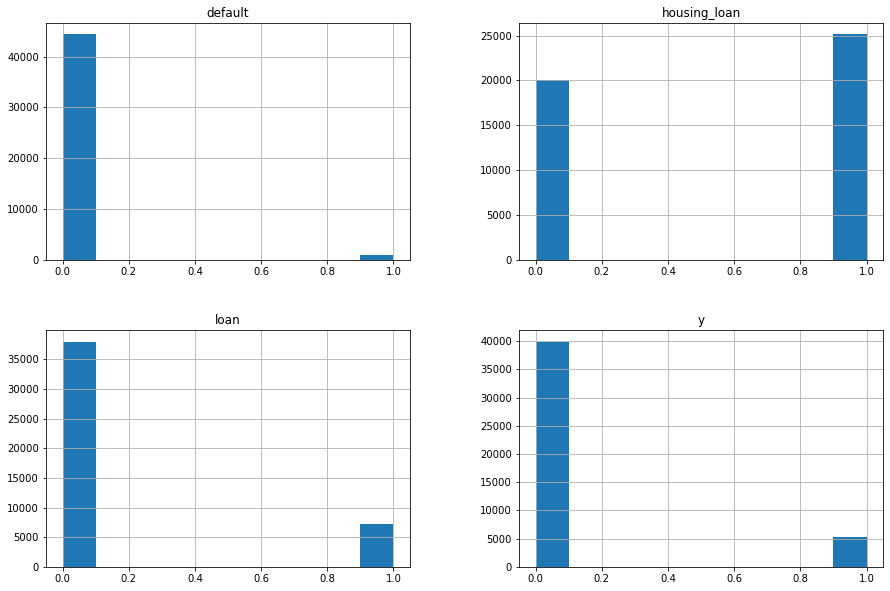

In [17]:
aux = bool_attributes.applymap(lambda x: 1 if x == True else 0)

aux.hist(figsize = [15, 10]);

# 2.0. FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Hypotheses

**1.** Customers older than 50 are more likely to subscribe;

**2.** Unemployed customers are the most unlikely to subscribe;

**3.** Customers whose education level is secondary are more likely to subscribe;

**4.** Defaulted customers are not likely to subscribe;

**5.** Customers who have not defaulted but with debt tend to subscribe;

**6.**  Campaign calling may last longer if the customer subscribes;

**7.** First contact is the only one that matters;

**8.** People who subscribed to the last marketing campaign tend to subscribe to a new one.

## 2.2. Features

In [19]:
df2.columns

Index(['age', 'job', 'marital_status', 'education_level', 'default', 'balance',
       'housing_loan', 'loan', 'contact_way', 'day_of_month_lc', 'month_lc',
       'duration_lc', 'contact_count', 'days_p', 'contact_count_p', 'y_p',
       'y'],
      dtype='object')

In [20]:
# Loans
df2['total_loan'] = (df2['loan'] | df2['housing_loan'])

# Days since last contact
df2['days_p'] = df2['days_p'].apply(lambda x: 10000 if x == -1 else x)

# Datetimes
df2['month_lc_num'] = df2["month_lc"].apply(lambda x: datetime.datetime.strptime(x, "%b").month)
df2["date_lc"] = df2.apply(lambda x: datetime.datetime(year = 2022, month = x['month_lc_num'], day = x['day_of_month_lc']), axis = 1)
df2['week_of_year_lc'] = df2['date_lc'].dt.weekofyear
df2['weekday_lc'] = df2["date_lc"].apply(lambda x: x.weekday())

# 3.0. VARIABLES FILTERING

In [21]:
df3 = df2.copy()

## 3.1. Row Filtering

In [22]:
df3 = df3[(df3['default'] == 0) & (df3['balance'] >= 0)]

## 3.2. Columns Selection

In [23]:
drop_cols = ['contact_way', 'contact_count', 'loan', 'housing_loan', 'month_lc', 'date_lc', 'default']
df3 = df3.drop(drop_cols, axis = 1)

# 4.0. Exploratory Data Analysis (EDA)

In [24]:
df4 = df3.copy()

In [25]:
num_attributes_df4 = df4.select_dtypes(include = ['int64', 'float64'])
cat_attributes_df4 = df4.select_dtypes(exclude = ['int64', 'float64'])

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

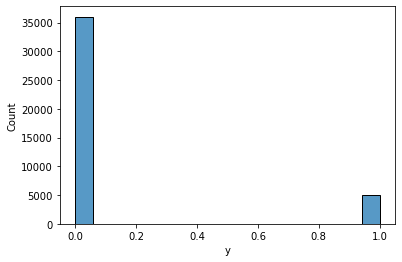

In [26]:
sns.histplot(df4['y'].apply(lambda x: int(x)));

### 4.1.2. Numerical Variable

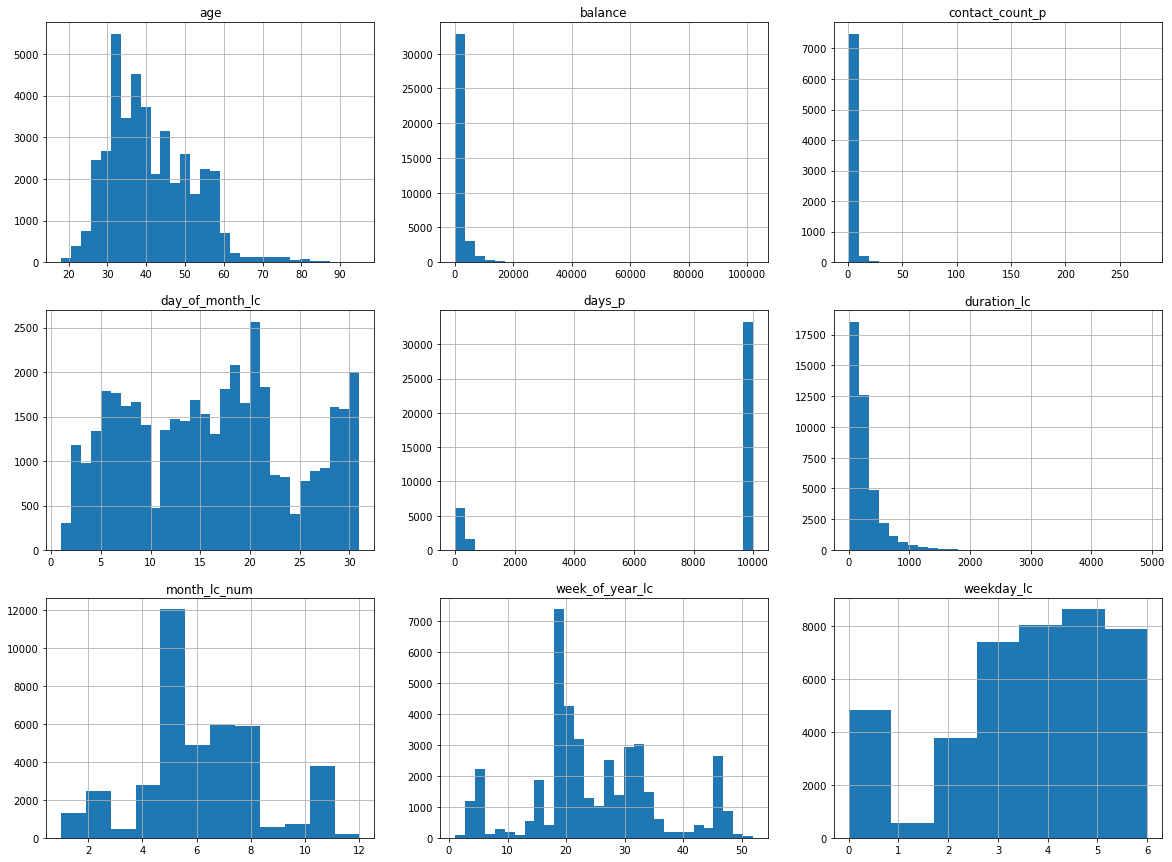

In [27]:
# AJEITAR LABEL DO ULTIMO GRAFICO

plt.figure(figsize = [20, 15])

# age
plt.subplot(3, 3, 1)
num_attributes_df4['age'].hist(bins = 30);
plt.title("age")

# balance
plt.subplot(3, 3, 2)
aux = num_attributes_df4[num_attributes_df4['balance'] > 0]['balance']
aux.hist(bins = 30);
plt.title("balance")

# contact_count_p
plt.subplot(3, 3, 3)
aux = num_attributes_df4[num_attributes_df4['contact_count_p'] > 0]['contact_count_p']
aux.hist(bins = 30);
plt.title("contact_count_p")

# day_of_month_lc
plt.subplot(3, 3, 4)
num_attributes_df4["day_of_month_lc"].hist(bins = 30);
plt.title("day_of_month_lc")

# days_p
plt.subplot(3, 3, 5)
aux = num_attributes_df4[num_attributes_df4['days_p'] > 0]['days_p']
aux.hist(bins = 30);
plt.title("days_p")

# duration_lc
plt.subplot(3, 3, 6)
num_attributes_df4['duration_lc'].hist(bins = 30);
plt.title("duration_lc")

# month_lc_num
plt.subplot(3, 3, 7)
num_attributes_df4['month_lc_num'].hist(bins = 12);
plt.title("month_lc_num")

# week_of_year_lc
plt.subplot(3, 3, 8)
num_attributes_df4['week_of_year_lc'].hist(bins = 30);
plt.title("week_of_year_lc")

# weekday_lc
plt.subplot(3, 3, 9)
num_attributes_df4['weekday_lc'].hist(bins = 7);
plt.title("weekday_lc");

### 4.1.3. Categorical Variable

## 4.2. Bivariate Analysis

### H1. Customers older than 50 are more likely to subscribe.
**False:** Customers younger than 50 are more likely to subscribe.

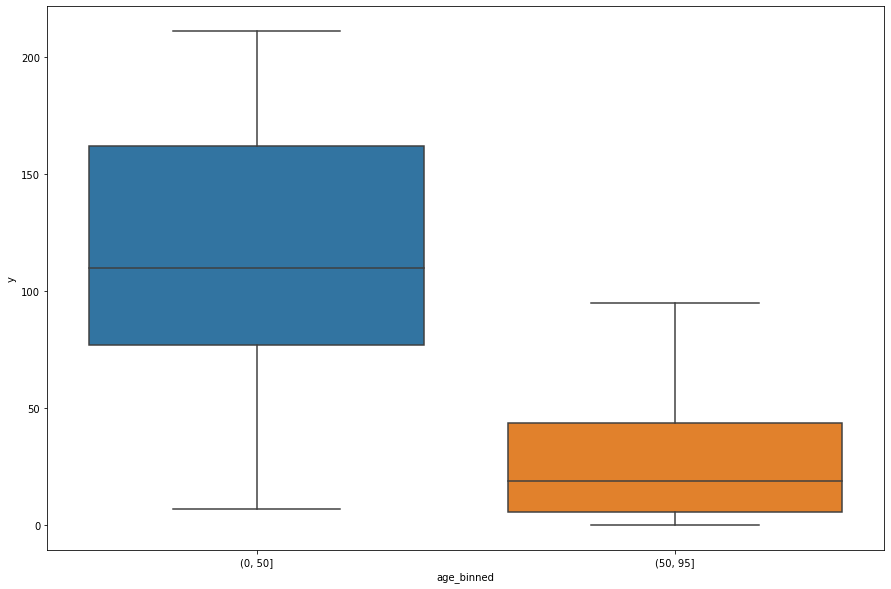

In [28]:
aux1 = df4.copy()[['age', 'y']].groupby('age').sum()['y'].reset_index()
aux2 = aux1.copy()

bins = [0, 50, aux1['age'].max()]
aux2['age_binned'] = pd.cut(aux1['age'], bins = bins)

plt.figure(figsize = [15, 10])
sns.boxplot(x = 'age_binned', y = 'y', data = aux2);

### H2. Unemployed customers are more likely not to subscribe.
**False:** The unemployed customers' subscription ratio is higher than the global ratio.

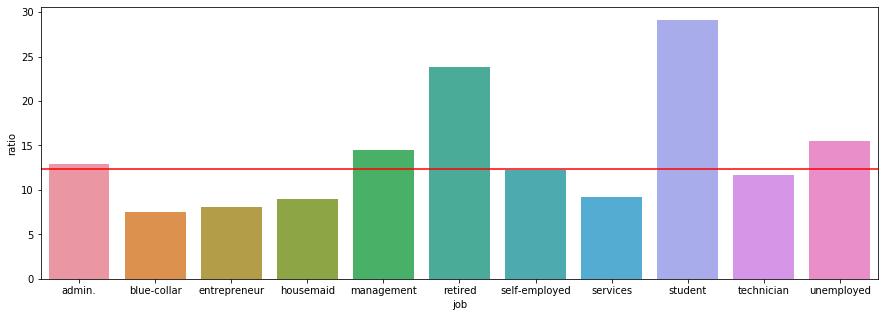

In [29]:
aux = df4.copy()[['job', 'y']]

aux2 = aux.groupby('job').count().reset_index()
aux2['subs'] = aux.groupby('job').sum().reset_index()['y']

global_ratio = aux['y'].sum()/aux.shape[0] * 100

aux2['ratio'] = aux2.apply(lambda x: x["subs"]/x['y'] * 100, axis = 1)

plt.figure(figsize = [15, 5])
ax = sns.barplot(x = 'job', y = 'ratio', data = aux2)
ax.axhline(y = global_ratio, color = 'red');

### H3. Customers whose education level is secondary are more likely to subscribe.
**False:** Customers whose education level is TERTIARY are more likely to subscribe

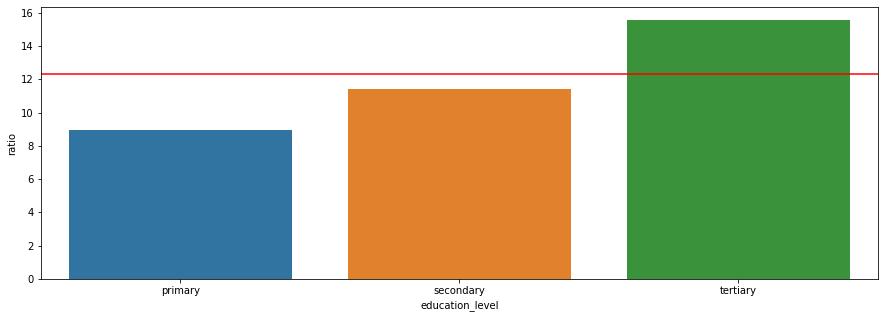

In [30]:
aux = df4.copy()[['education_level', 'y']]

aux2 = aux.groupby('education_level').count().reset_index()
aux2['subs'] = aux.groupby('education_level').sum().reset_index()['y']

global_ratio = aux['y'].sum()/aux.shape[0] * 100
aux2['ratio'] = aux2.apply(lambda x: x["subs"]/x['y'] * 100, axis = 1)

plt.figure(figsize = [15, 5])
ax = sns.barplot(x = 'education_level', y = 'ratio', data = aux2)
ax.axhline(y = global_ratio, color = 'red');

### H4. <s>Defaulted customers are not likely to subscribe;</s>
**-** Defaulted customers are already discarded.

### H5. Customers who have not defaulted but with debt tend to subscribe.
**False:** Customers who have not defaulted but with debt DO NOT tend to subscribe.

Text(0, 0.5, 'y Sum')

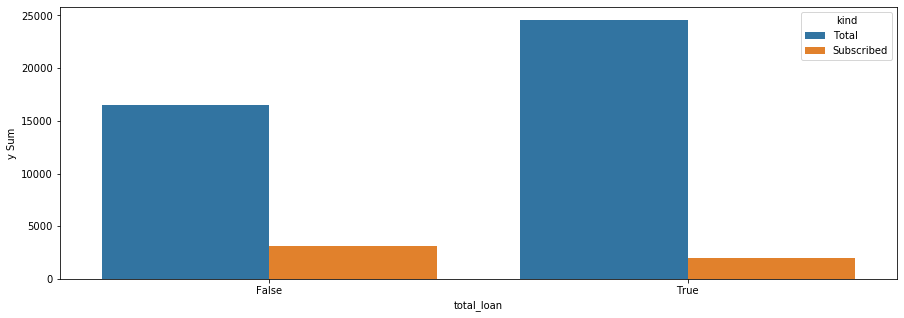

In [31]:
aux1 = df4.copy()[['total_loan', 'y']]

aux2 = aux1.groupby('total_loan').count().reset_index()
aux2['kind'] = ['Total', "Total"]

aux3 = aux1.groupby('total_loan').sum().reset_index()
aux3['kind'] = ['Subscribed', "Subscribed"]

aux4 = pd.concat([aux2, aux3], axis = 0)


plt.figure(figsize = [15, 5])
sns.barplot(x = 'total_loan', y = 'y', data = aux4, hue = 'kind')
plt.ylabel("y Sum")

### H6. Campaign calling may last longer if the customer subscribes.
**Truth:** Customers that will subscribe tend to have a longer calling.

(-100, 2000)

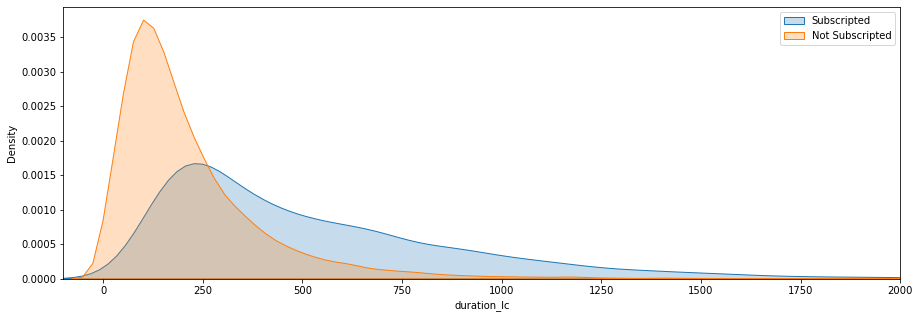

In [32]:
# REVER -1


aux = df4.copy()[['duration_lc', 'y']]

plt.figure(figsize = [15, 5])
sns.kdeplot(x = 'duration_lc', data = aux[aux['y'] == True], shade = True)
sns.kdeplot(x = 'duration_lc', data = aux[aux['y'] == False], shade = True)
plt.legend(["Subscripted", "Not Subscripted"])
plt.xlim([-100, 2000])

### H7. First contact is the only one that matters.
**False:** The number of contacts is not relevant information to predict subscription.

(-3, 20)

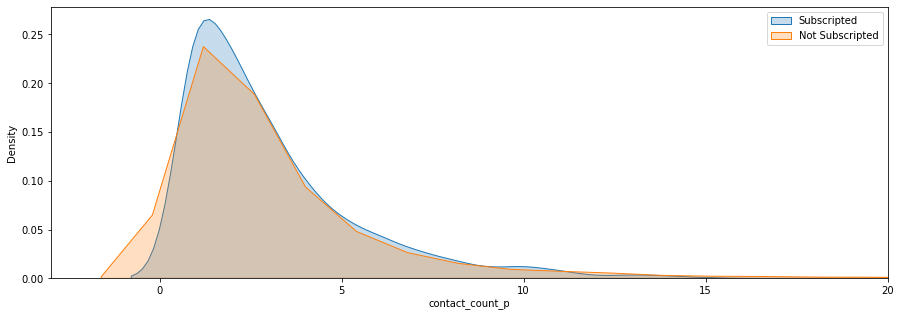

In [33]:
aux = df4[df4['contact_count_p'] != 0][['contact_count_p', 'y_p']]

plt.figure(figsize = [15, 5])
sns.kdeplot(x = 'contact_count_p', data = aux[aux['y_p'] == "success"], shade = True)
sns.kdeplot(x = 'contact_count_p', data = aux[aux['y_p'] != 'success'], shade = True)
plt.legend(["Subscripted", "Not Subscripted"])
plt.xlim([-3, 20])

### H8. People who subscribed to the last marketing campaign tend to subscribe to a new one.
**Truth** Around 65% of people who subscribed to the last campaign subscribed to the new one.

In [34]:
aux = df4.copy()[['y_p', 'y']]
aux['y_p'] = aux['y_p'].replace(to_replace = ['failure', 'success', 'other'], value = [False, True, False])
aux['count'] = np.ones(aux.shape[0])
aux2 = aux.groupby(['y_p', 'y']).sum()

TT = float(aux2.loc[(True, True)])
TF = float(aux2.loc[(True, False)])

print("{:.2f}%".format(TT/(TT+TF) * 100))
aux2

64.93%


count
y_p   y             
False False  35491.0
      True    4085.0
True  False    524.0
      True     970.0

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

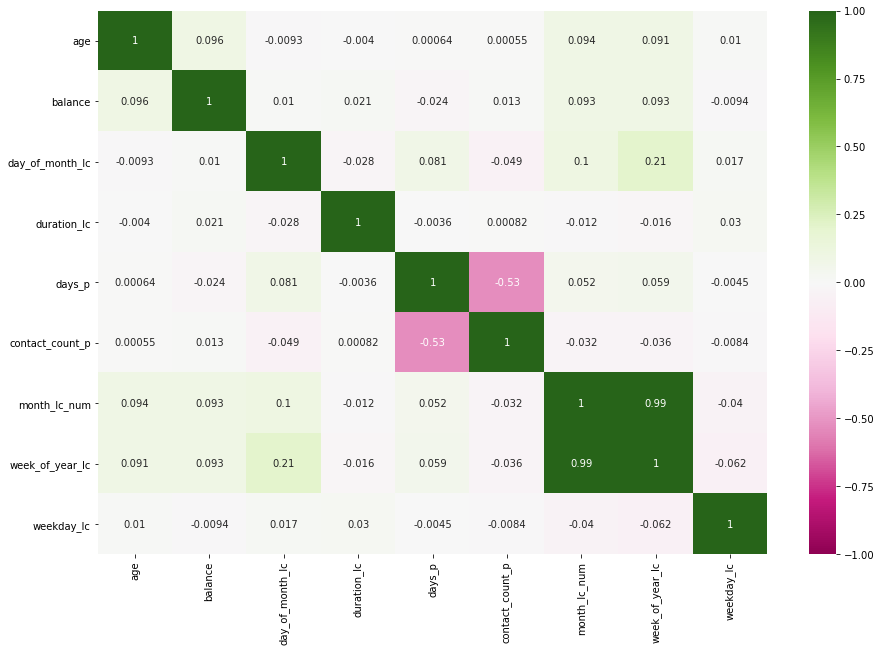

In [35]:
plt.figure(figsize = [15, 10])
sns.heatmap(data = num_attributes_df4.corr(), cmap = "PiYG", vmin = -1, vmax = 1, annot = True)
plt.yticks(rotation = 0);

### 4.3.2. Categorical Attributes

In [36]:
cat_corr_dict = {}
for i in cat_attributes_df4.columns:
    cat_corr_dict[i] = []
    for j in cat_attributes_df4.columns:
        cat_corr_dict[i].append(cramer_v(cat_attributes_df4[i], cat_attributes_df4[j]))
        
cat_corr_pd = pd.DataFrame(cat_corr_dict)
cat_corr_pd.index = cat_corr_pd.columns

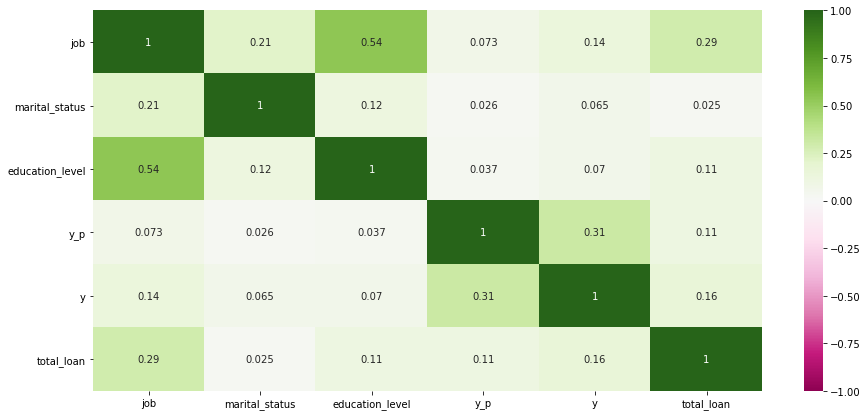

In [37]:
plt.figure(figsize = [15, 7])
sns.heatmap(data = cat_corr_pd, cmap = "PiYG", vmin = -1, vmax = 1, annot = True)
plt.yticks(rotation = 0);

# 5.0. DATA PREPARATION

In [38]:
df5 = df4.copy()
num_attributes_df5 = df5.select_dtypes(include = ['int64', 'float64'])
cat_attributes_df5 = df5.select_dtypes(exclude = ['int64', 'float64'])

## 5.1. Standardization

### 5.1.1 Encoding

In [39]:
# job - Frequency Encoding
aux = df5.groupby(['job']).count().iloc[:, :1]
aux.columns = ['job']
summation = aux["job"].sum()
aux['job'] = aux['job'].apply(lambda x: x/summation)
df5['job'] = df5['job'].map(aux.to_dict()['job'])

# maritial_status - One Hot Econding
df5 = pd.get_dummies(df5, prefix = "is", columns = ['marital_status'])

# education_level - Ordinal Encodinh
education_dict = {"primary": 1, 'secondary':2, 'tertiary': 3}
df5['education_level'] = df5['education_level'].map(education_dict)

# total_loan
df5['total_loan'] = df5['total_loan'].apply(lambda x: 1 if x else 0)

# y_p
y_p_dict = {'failure': -1, 'other': 0, 'success': 1}
df5['y_p'] = df5['y_p'].map(y_p_dict)

# y
df5['y'] = df5['y'].apply(lambda x: 1 if x else 0)

### 5.1.2. Log Transformation

In [40]:
# age
df5['age'] = df5['age'].apply(lambda x: np.log1p(x))

# balance 
df5['balance'] = df5['balance'].apply(lambda x: np.log1p(x))

# duration_lc
df5['duration_lc'] = df5['duration_lc'].apply(lambda x: np.log1p(x))

### 5.1.3. Nature Transformation

In [41]:
# day_of_month_lc
df5['day_of_month_lc_sin'] = np.sin(df5['day_of_month_lc'] * 2 * np.pi / 30)
df5['day_of_month_lc_cos'] = np.cos(df5['day_of_month_lc'] * 2 * np.pi / 30)

# month_lc_num
df5['month_lc_num_sin'] = np.sin(df5['month_lc_num'] * 2 * np.pi / 12)
df5['month_lc_num_cos'] = np.cos(df5['month_lc_num'] * 2 * np.pi / 12)

# weekday_lc
df5['weekday_lc_sin'] = np.sin(df5['weekday_lc'] * 2 * np.pi / 7)
df5['weekday_lc_cos'] = np.cos(df5['weekday_lc'] * 2 * np.pi / 7)

# week_of_year_lc
df5['week_of_year_lc_sin'] = np.sin(df5['week_of_year_lc'] * 2 * np.pi / 52)
df5['week_of_year_lc_cos'] = np.cos(df5['week_of_year_lc'] * 2 * np.pi / 52)

## 5.2. Scaling

### 5.2.1 Standardization

In [42]:
# balance, duration_lc
ss = StandardScaler()
df5[['balance', 'duration_lc']] = ss.fit_transform(df5[['balance', 'duration_lc']])

### 5.2.2 Robust Scaling

In [43]:
# days_p, contact_count_p
rs = RobustScaler()
df5[['days_p', 'contact_count_p']] = rs.fit_transform(df5[['days_p', 'contact_count_p']])

### 5.2.3 Min Max Scaling

In [44]:
# age
mms = MinMaxScaler()
df5[['age']] = mms.fit_transform(df5[['age']])